# Train Fasttext language model using Gensim

In [1]:
import pandas as pd
import numpy as np
import collections
import gensim 
from gensim.models import word2vec, phrases
from gensim.parsing.preprocessing import remove_stopwords, strip_punctuation, strip_numeric,\
                    strip_non_alphanum, strip_multiple_whitespaces, strip_short
from textblob import TextBlob, Word

import re
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
%matplotlib inline

In [2]:
import os
fc=0
for el in os.listdir("."):
    fc+=1
    print(" - ",el)
print("found",fc,"files!")

 -  .venv
 -  1_trainRecipeEmbeddings.ipynb
 -  1_trainRecipeEmbeddings_files
 -  2_indexRecipeData.ipynb
 -  2_indexRecipeData.md
 -  README.md
found 6 files!


In [3]:
files = [
    'data/dataset-ayam.csv',
    'data/dataset-ikan.csv',
    'data/dataset-kambing.csv',
    'data/dataset-sapi.csv',
    'data/dataset-tahu.csv',
    'data/dataset-tempe.csv',
    'data/dataset-telur.csv',
    'data/dataset-udang.csv'
]

In [4]:
raw = pd.read_csv(r"data/dataset-ayam.csv")
df = raw.copy()
df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'data/dataset-ayam.csv'

# Basic insights and data processing

In [91]:
#we keep the Translated versions of Ingredients and Instructions (already pre-processed data)
columns_to_drop = ['URL']
df_indoRecipes = df.drop(columns = columns_to_drop).dropna()

df_indoRecipes.head()

,Title,Ingredients,Steps,Loves
0,Lumpia udang kulit tahu ala fe',50 gram ayam potong kotak kecil--200 gram udan...,Campur ayam & udang dengan semua bumbu & daun ...,4
1,Bakso Ayam Udang Keto,400 gr ayam giling--250 gr udang kupas--3 telu...,"Campur semua bahan dalam food processor, kecua...",2
2,Udang ala pop corn,1/4 kg udang basah ukuran sedang--1 bungkus ko...,Buang kepala dan cangkang udang.--Cuci bersih ...,2
3,Bakwan Udang Sederhana,1/2 kg Tepung terigu (sudah di ayak)--1/2 Udan...,"Haluskan bawang putih, garam, picin dan merica...",0
4,Udang Goreng Tepung Mayonaise,300 gr udang (buang kepalanya)--Jeruk nipis--T...,"Cuci bersih udang, tambahkan jeruk nipis supay...",6


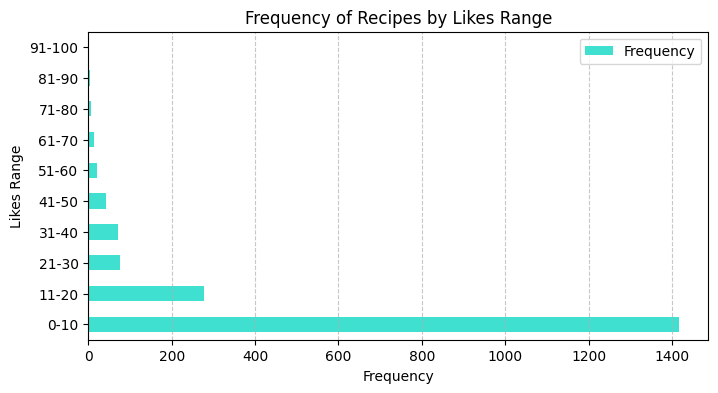

In [92]:
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]  # You can adjust these ranges based on your data
labels = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100']

df_indoRecipes['Loves_bin'] = pd.cut(df_indoRecipes['Loves'], bins=bins, labels=labels, right=True)

# Count frequencies in each bin
counts = df_indoRecipes['Loves_bin'].value_counts().sort_index()

# Create a DataFrame for plotting
mc = pd.DataFrame(counts).reset_index()
mc.columns = ['Likes Range', 'Frequency']

# Plot the data
mc.plot(kind='barh', x='Likes Range', color='turquoise', figsize=(8,4))
plt.xlabel('Frequency')
plt.ylabel('Likes Range')
plt.title('Frequency of Recipes by Likes Range')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

                       File  Row Count
0     data/dataset-ayam.csv       1916
1     data/dataset-ikan.csv       1932
2  data/dataset-kambing.csv       1896
3     data/dataset-sapi.csv       1958
4     data/dataset-tahu.csv       1985
5    data/dataset-tempe.csv       1986
6    data/dataset-telur.csv       1974
7    data/dataset-udang.csv       1994


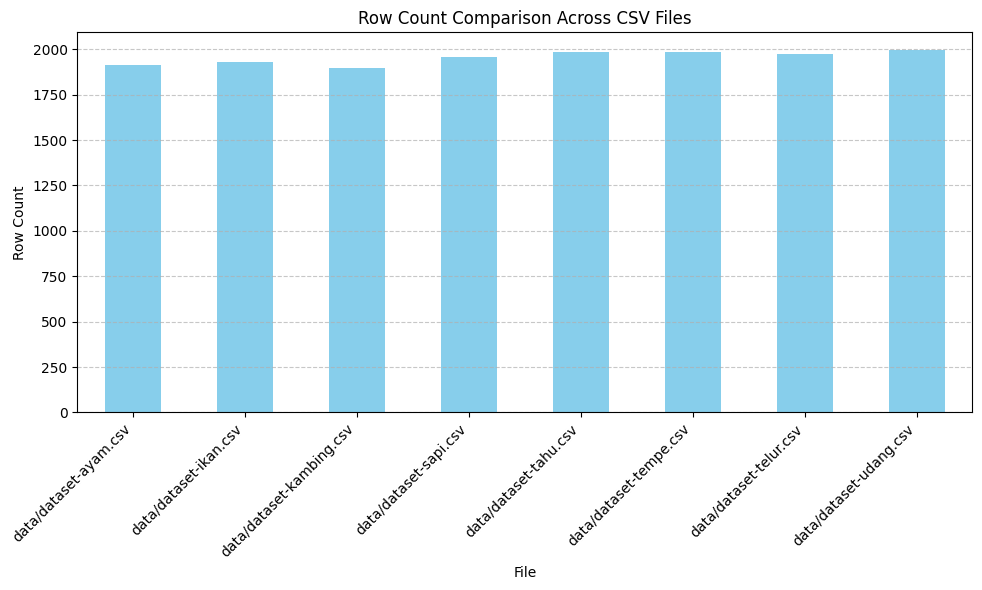

In [93]:
row_counts_dict = {}

# Read each CSV and count the rows
for file in files:
    try:
        # Read the CSV file
        df = pd.read_csv(file)
        
        # Count the number of rows
        row_count = len(df)
        
        # Store row count in the dictionary
        row_counts_dict[file] = row_count
    except Exception as e:
        print(f"Error processing {file}: {e}")

# Convert row_counts_dict to a DataFrame for plotting
row_counts_df = pd.DataFrame(list(row_counts_dict.items()), columns=['File', 'Row Count'])

# Print the row counts DataFrame
print(row_counts_df)

# Plot the row counts
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting the row counts
row_counts_df.plot(kind='bar', x='File', y='Row Count', ax=ax, color='skyblue', legend=False)
plt.title('Row Count Comparison Across CSV Files')
plt.xlabel('File')
plt.ylabel('Row Count')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout to fit labels
plt.tight_layout()

# Show the plot
plt.show()


In [94]:
#some more processing, dropping columns in hindi, copied from a notebook in kaggle
#df_indoRecipes = df_indoRecipes['TranslatedIngredients']
def isEnglish(s):
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True
    
#create boolean mask
mask = df_indoRecipes['Ingredients'].apply(isEnglish)
df_indoRecipes = df_indoRecipes[mask].dropna()

print("Shape of recipe data:",df_indoRecipes.shape)

Shape of recipe data: (1847, 5)


In [95]:
#more preprocessing on the text fields
df_indoRecipes['Ingredients'] = df_indoRecipes['Ingredients'].apply(lambda x: x.lower())

total_ingredients = []
all_receipes_ingredients =  []
for i in range(len(df_indoRecipes)):
    all_ingredients = list()
    #split each recipe into different ingredients
    try:
        ingred = df_indoRecipes.loc[i, "Ingredients"][1:-1]
    except:
        continue;
      
    for ing in (ingred.split(',')):
        ing = remove_stopwords(ing)
        ing = strip_numeric(ing)
        ing = re.sub(r'\(.*oz.\)|(®)|(.*ed)|(.*ly)|tast|sprig|inch|purpose|flmy|taste|boneless|skinless|chunks|fresh|large|cook drain|green|frozen|ground|tablespoon|teaspoon|cup','',ing).strip()
        ing = strip_short(ing,2)
        ing = strip_multiple_whitespaces(ing)
        ing = strip_punctuation(ing)
        ing = strip_non_alphanum(ing)
        
        #convert plurals to singular e.g. tomatoes --> tomato
        # ing = (" ".join(TextBlob(ing).words.singularize()))
        if len(ing)>0:
            all_ingredients.append(ing)
            total_ingredients.append(ing)
    all_receipes_ingredients.append(all_ingredients)
counts_ingr = collections.Counter(total_ingredients)
all_receipes_ingredients.append(all_ingredients)

---- Most Common Ingredients ----
[('gula', 60), ('garam', 52), ('gr udang', 45), ('ap rasa ', 33), ('ap ', 29), ('udang', 27), ('iris  siung bawang putih', 25), ('ang', 23), ('ikit air ', 22), ('kupas', 15), ('ri', 13), ('garam ', 11), ('lada', 11), ('iris tipis  siung bawang putih', 10), ('bersihkan', 10), ('buang kepala', 10), ('merica', 10), ('gram udang', 9), ('gula ', 8), ('ap', 8), ('cuci', 8), ('merica ', 7), ('ap rasa', 7), ('gula pasir', 7), ('iris  siung bawang merah', 6)]


---- Least Common Ingredients ----
[('dang tempe pete bawang merah bawang putih cabai merah tomat secukupnya gula dan garam ', 1), ('cuci tiriskn  bgks tepung serbaguna  sdm terigu minyak untuk menggoreng secukupnya air ', 1), ('ri garam gula merica ', 1), ('ap rasa garam dan gula secukup nya minyak goreng ', 1), ('gram udang  buah jagung  buah bawang daun  siung bawang putih  siung bawang merah tepung terigu kunyit air sesuai selera gula', 1), ('ap minyak untuk menggoreng ', 1), ('gr udang kupas  bh ana

<Axes: ylabel='word'>

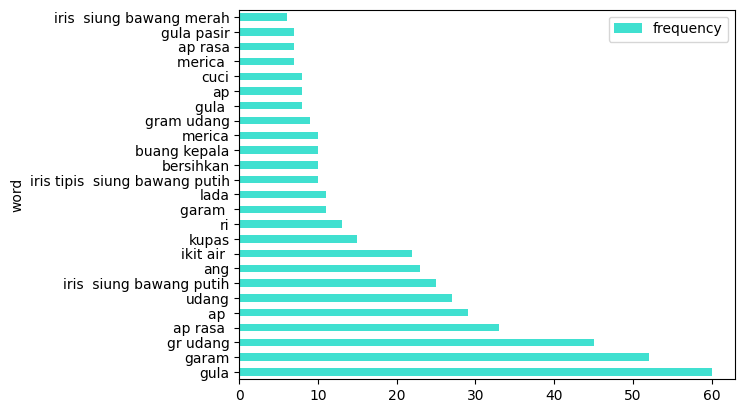

In [96]:
#find the most common ingredients used across all recipes
print ("---- Most Common Ingredients ----")
print (counts_ingr.most_common(25))

print ("\n")
#find the most common ingredients used across all recipes
print ("---- Least Common Ingredients ----")
print (counts_ingr.most_common()[-10:])
print("type counts ingr",type(counts_ingr))

most_common = counts_ingr.most_common(25)
mc = pd.DataFrame(most_common, columns=['word', 'frequency'])

#print("\nMost common:\n", mc)
mc.plot(kind='barh', x='word', align='center', color='turquoise')

In [97]:
#convert to lower case
df_indoRecipes['Steps'] = df_indoRecipes['Steps'].apply(lambda x: x.lower())

#total_ingredients = []
all_instructions =  []

#len(df_indoRecipes)
for i in range(len(df_indoRecipes)):
    #split each recipe into different ingredients
    try:
        instrs = df_indoRecipes.loc[i, "Ingredients"][1:-1]
        #print("instrs\n",instrs)
    except:
        continue;      
    for instr in (instrs.split('.')):
        instr = remove_stopwords(instr)
        instr = strip_numeric(instr)
        #instr = re.sub(r'\(.*oz.\)|(®)|(.*ed)|(.*ly)|tast|sprig|inch|purpose|flmy|taste|boneless|skinless|chunks|fresh|large|cook drain|green|frozen|ground|tablespoon|teaspoon|cup','',ing).strip()
        instr = strip_short(instr,2)
        instr = strip_multiple_whitespaces(instr)
        instr = strip_punctuation(instr)
        instr = strip_non_alphanum(instr)
        #convert plurals to singular e.g. tomatoes --> tomato
        # instr = (" ".join(TextBlob(instr).words.singularize()))
        if len(instr)>0:
            all_instructions.append(instr)

print("len",len(all_instructions))

#formatting the column in a way the gensim takes it
all_instructions_splitted = [sentx.split() for sentx in all_instructions]
df_indoRecipes.to_pickle("processed/df_indoRecipes.pkl")

len 1807


In [98]:
#record the number of ingredients for each recipe, 
#add cleaned instructions for training recipe embeddings
#add cleaned ingredients back to original dataframe
df_indoRecipes['clean_ingredients'] = pd.Series(all_receipes_ingredients)
df_indoRecipes = df_indoRecipes.dropna()
df_indoRecipes['ingredient_count'] =  df_indoRecipes.apply(lambda row: len(row['clean_ingredients']), axis = 1)
df_indoRecipes['clean_instructions'] = df_indoRecipes['Steps'].apply(lambda x: x.lower())
df_indoRecipes['clean_instructions']

0       campur ayam & udang dengan semua bumbu & daun ...
1       campur semua bahan dalam food processor, kecua...
2       buang kepala dan cangkang udang.--cuci bersih ...
4       cuci bersih udang, tambahkan jeruk nipis supay...
7       cuci udang bersih, lumuri dengan jeruk nipis--...
                              ...                        
1699    kupas udang, sisihkan kepala nya. kepala nya d...
1700    bersihkan udang, belah bagian atasnya, lumuri ...
1701    siap kan semua bahan, potong dan cuci bersih. ...
1702    panaskan wajan, tuang minyak tunggu hingga pan...
1703    panaskan minyak setelah panas masukan bumbu ha...
Name: clean_instructions, Length: 1568, dtype: object

In [99]:
df_indoRecipes.to_pickle("processed/df_indoRecipes.pkl")

In [100]:
#function to process the column 'recipe' to the format of list-of-lists
import re
from gensim.parsing.preprocessing import remove_stopwords, strip_punctuation, strip_numeric, strip_non_alphanum, strip_multiple_whitespaces, strip_short

def process_recipe(recipe):
    recipeProcessed = []
    for ing in (recipe.split(',')):
        ing = remove_stopwords(ing)
        ing = strip_numeric(ing)
        ing = re.sub(r'\(.*oz.\)|(®)|(.*ed)|(.*ly)|tast|sprig|inch|purpose|flmy|taste|boneless|skinless|chunks|fresh|large|cook drain|green|frozen|ground|tablespoon|teaspoon|recipe|cup','',ing).strip()
        ing = strip_short(ing,2)
        ing = strip_multiple_whitespaces(ing)
        ing = strip_punctuation(ing)
        ing = strip_non_alphanum(ing)
        if ing:
            #print("ing",ing)
            recipeProcessed.append(ing)
    #print("recipeProcessed",len(recipeProcessed),recipeProcessed)
    return [oneInstr.split() for oneInstr in recipeProcessed]

process_recipe(df_indoRecipes['clean_instructions'][11])

[['bersihkan', 'udang', 'iris', 'bawang', 'merah'],
 ['bawang',
  'putih',
  'dan',
  'bawang',
  'bombai',
  'menjadi',
  'bagian',
  'yang',
  'kecil',
  'dan',
  'tipis',
  'siapkan',
  'wajan',
  'teflon'],
 ['nyalakan', 'api', 'kecil'],
 ['kemudian',
  'masukan',
  'mentega',
  'hingga',
  'leleh',
  'dan',
  'panas',
  'tumis',
  'bawang',
  'merah',
  'dan',
  'bawang',
  'putih',
  'sebentar',
  'saja',
  'sekitar',
  'menit',
  'lalu',
  'masukan',
  'bawang',
  'bombai',
  'tumis',
  'lagi',
  'hingga',
  'harum',
  'masukkan',
  'udang'],
 ['garam'],
 ['saus', 'tiram'],
 ['as',
  'dan',
  'saus',
  'tomat',
  'aduk',
  'hingga',
  'rata',
  'jika',
  'sudah',
  'matang'],
 ['angkat', 'dan', 'sajikan']]

In [101]:
#adding clean instructions
df_indoRecipes['clean_instructions'] = df_indoRecipes['clean_instructions'].apply(lambda x:process_recipe(x))
print(df_indoRecipes['clean_instructions'][1])

[['campur', 'semua', 'bahan', 'dalam', 'food', 'processor'], ['kecuali', 'daun', 'bawang', 'dan', 'minyak', 'goreng', 'tuang', 'dalam', 'baskom', 'lalu', 'taburi', 'daun', 'bawang', 'dan', 'minyak', 'goreng'], ['ang', 'bulatkan', 'adonan', 'dengan', 'menggunakan', 'dua', 'sendok', 'lalu', 'goreng', 'sampai', 'matang', 'adonan', 'akan', 'mengembang', 'saat', 'di', 'wajan'], ['tapi', 'kembali', 'kempes', 'stelah', 'diangkat']]


In [102]:
# Menggabungkan instruksi yang terpecah menjadi satu list per resep
all_Sentences = []
for instructions in df_indoRecipes['clean_instructions']:
    # Gabungkan semua bagian instruksi dari setiap resep
    combined_instructions = [word for sentence in instructions for word in sentence]
    all_Sentences.append(combined_instructions)

# Periksa contoh hasilnya
print(all_Sentences[:3])  # Menampilkan 3 resep pertama yang sudah digabungkan


[['campur', 'ayam', 'udang', 'dengan', 'semua', 'bumbu', 'daun', 'bawang', 'aduk', 'rata', 'sesudah', 'rata', 'masukkan', 'tepung', 'sagu', 'terigu', 'putih', 'telur', 'aduk', 'rata', 'isikan', 'ke', 'lembaran', 'kulit', 'kembang', 'tahu', 'lipat', 'seperti', 'melipat', 'lumpia', 'sambil', 'dipadatkan', 'agar', 'rapi', 'bentuk', 'agak', 'pipih', 'jangan', 'terlalu', 'bulat', 'olesi', 'putih', 'telur', 'diujung', 'lipatan', 'agar', 'merekat', 'rapat', 'kukus', 'sekitar', 'menit', 'hingga', 'matang', 'angkat', 'dinginkan', 'siap', 'digoreng', 'dengan', 'api', 'kecil', 'sebentar', 'anakku', 'suka', 'digoreng', 'agak', 'lama', 'dengan', 'kuning', 'telur', 'kocok', 'sisa', 'adonan', 'tadi', 'nanti', 'jadi', 'ada', 'kayak', 'jala', 'crispynya', 'yang', 'gurih', 'kering', 'angkat', 'tiriskan', 'jika', 'sudah', 'digoreng', 'matang', 'sajikan', 'dengan', 'dipotong', 'diagonal', 'potong', 'serong', 'siap', 'disantap', 'dengan', 'saus', 'sambal', 'botol', 'yang', 'biasanya', 'saya', 'rebus', 'den

In [103]:
all_Sentences = []
for instructions in df_indoRecipes['clean_instructions']:
    # Gabungkan semua bagian instruksi dari setiap resep
    combined_instructions = [word for sentence in instructions for word in sentence]
    all_Sentences.append(combined_instructions)

# Cek apakah all_Sentences adalah list of lists
print(type(all_Sentences))  # Seharusnya <class 'list'>
print(type(all_Sentences[1]))  # Seharusnya <class 'list'>
print(all_Sentences[2])

<class 'list'>
<class 'list'>
['buang', 'kepala', 'dan', 'cangkang', 'udang', 'cuci', 'bersih', 'udang', 'tepung', 'bumbu', 'dibagi', 'jadi', 'adonan', 'adonan', 'basah', 'dan', 'adonan', 'kering', 'masukkan', 'udang', 'ke', 'dalam', 'adonan', 'tepung', 'bumbu', 'kering', 'gulirkan', 'ke', 'dlm', 'tepung', 'sambil', 'ditekan', 'lalu', 'masukkan', 'ke', 'dalam', 'tepung', 'bumbu', 'adonan', 'basah', 'gulirkan', 'lagi', 'sambil', 'di', 'tekan', 'lalu', 'masukkan', 'lagi', 'di', 'adonan', 'tepung', 'bumbu', 'kering', 'sambil', 'ditekan', 'agar', 'tepung', 'menempel', 'sempurna', 'panaskan', 'minyak', 'goreng', 'lalu', 'goreng', 'udang', 'sampai', 'kuning', 'keemasan', 'angkat', 'dan', 'tiriskan', 'sajikan', 'selagi', 'hangat']


# recipe embeddings using gensim

In [104]:
import gensim
print(gensim.__version__)

4.3.3


In [105]:
from gensim.models import FastText

# Inisialisasi model FastText
model_indofood_fasttext = FastText(vector_size=100, window=5, min_count=5, workers=4, sg=1)

# Bangun vocab dari data
print(f"Jumlah kalimat dalam all_Sentences: {len(all_Sentences)}")
model_indofood_fasttext.build_vocab(corpus_iterable=all_Sentences)

# Latih model
print("Mulai training...")
model_indofood_fasttext.train(corpus_iterable=all_Sentences, total_examples=len(all_Sentences), epochs=5)

# Simpan model
print("Menyimpan model...")
model_indofood_fasttext.save("models/model_indofood_fasttext.model")
print("Model tersimpan.")


Jumlah kalimat dalam all_Sentences: 1568
Mulai training...
Menyimpan model...
Model tersimpan.


In [106]:
#model_indianfood_fasttext.save("models/model_indianfood_fasttext.model")
total_words1 = model_indofood_fasttext.corpus_total_words
print(total_words1,"words in Recipe based model Corpus!")

model_indofood_fasttext.wv.most_similar("ayam")

85946 words in Recipe based model Corpus!


[('parut', 0.9342042803764343),
 ('bayam', 0.9332168698310852),
 ('powder', 0.903688907623291),
 ('butir', 0.8978109359741211),
 ('kanji', 0.8950783014297485),
 ('ketumbar', 0.8919031620025635),
 ('sdt', 0.8860217332839966),
 ('kelapa', 0.8856028914451599),
 ('secara', 0.8846874833106995),
 ('sejumput', 0.8833997249603271)]

In [107]:
model_indofood_fasttext.wv.most_similar("masak ayam")

[('masako', 0.9831702709197998),
 ('madu', 0.9561579823493958),
 ('hampir', 0.9508002400398254),
 ('toge', 0.9457502365112305),
 ('oregano', 0.9421865940093994),
 ('tggu', 0.934999942779541),
 ('tauco', 0.9345489740371704),
 ('susut', 0.9340965151786804),
 ('pelan', 0.9327778816223145),
 ('tambhkan', 0.9321441650390625)]

In [108]:
model_indofood_fasttext.wv.most_similar("ayam bakar")

[('ganti', 0.972353458404541),
 ('membuat', 0.9661018252372742),
 ('resep', 0.961198627948761),
 ('bakar', 0.9576942920684814),
 ('hasil', 0.9576921463012695),
 ('gigi', 0.9545421600341797),
 ('ibu', 0.9539898633956909),
 ('bs', 0.9538554549217224),
 ('kain', 0.951765239238739),
 ('stok', 0.9514472484588623)]

In [109]:
#defined functions to get to embeddings for recipes
def getSentenceEmbedding(sentence):
    countFound = 0
    embeddingList = []
    for wordx in sentence:
        try:
            vector1 = model_indofood_fasttext.wv[wordx]
            #print("word",wordx, vector1[:3])
            embeddingList.append(vector1)
            countFound+=1
        except:
            continue;
    sumEmbeddings = sum(embeddingList)
    return np.true_divide(sumEmbeddings, countFound)  

def getRecipeEmbedding(instruction):
    embeddingList = []
    for sentence in instruction:
        embeddingList.append(getSentenceEmbedding(sentence))
    sumEmbeddings = sum(embeddingList)
    return np.true_divide(sumEmbeddings, len(instruction))  

In [110]:
df_indoRecipes['recipe_embedding_fasttext'] =  df_indoRecipes.apply(lambda row: getRecipeEmbedding(row['clean_instructions']), axis = 1)

/var/folders/47/p1nz1hvx16xb5gzw123rjhs00000gn/T/ipykernel_28377/939707801.py:14: RuntimeWarning: invalid value encountered in divide
  return np.true_divide(sumEmbeddings, countFound)


In [111]:
#checking out the new column
df_indoRecipes.to_pickle('processed/df_indoRecipes.pkl')
df_indoRecipes.head()

,Title,Ingredients,Steps,Loves,Loves_bin,clean_ingredients,ingredient_count,clean_instructions,recipe_embedding_fasttext
0,Lumpia udang kulit tahu ala fe',50 gram ayam potong kotak kecil--200 gram udan...,campur ayam & udang dengan semua bumbu & daun ...,4,0-10,[gram ayam potong kotak kecil gram udang besa...,2,"[[campur, ayam, udang, dengan, semua, bumbu, d...","[0.04220629, -0.17580448, -0.036855042, -0.092..."
1,Bakso Ayam Udang Keto,400 gr ayam giling--250 gr udang kupas--3 telu...,"campur semua bahan dalam food processor, kecua...",2,0-10,[gr ayam giling gr udang kupas telur ayam ut...,2,"[[campur, semua, bahan, dalam, food, processor...","[0.08354704, -0.1697976, -0.09361218, -0.02692..."
2,Udang ala pop corn,1/4 kg udang basah ukuran sedang--1 bungkus ko...,buang kepala dan cangkang udang.--cuci bersih ...,2,0-10,[ang bungkus kobe tepung ayam super crispy se...,1,"[[buang, kepala, dan, cangkang, udang, cuci, b...","[0.1136707, -0.17281604, -0.12029305, 0.054842..."
4,Udang Goreng Tepung Mayonaise,300 gr udang (buang kepalanya)--jeruk nipis--t...,"cuci bersih udang, tambahkan jeruk nipis supay...",6,0-10,[ap rasa daun jeruk bumbu dihaluskan siung ba...,1,"[[cuci, bersih, udang], [alam, adonan, cair, t...","[0.0755907, -0.21281813, -0.041293688, -0.0729..."
7,Sambal udang goreng,1/4 kg udang--2 buah jeruk nipis--minyak goren...,"cuci udang bersih, lumuri dengan jeruk nipis--...",7,0-10,[gr udang secukupnya jahe memarkan secukupnya ...,1,"[[cuci, udang, bersih], [lumuri, dengan, jeruk...","[-0.018232431, -0.28495473, 0.0048255175, -0.0..."


In [112]:
#finding similar food-items using trained embeddings only

from numpy import dot
from numpy.linalg import norm

def find_Similar_dish(xx,embeddingToUse):
    #recipe_embedding_fasttext

    a = df_indoRecipes.loc[xx, embeddingToUse]
    orn = df_indoRecipes.loc[xx, "Title"]
    #print(orn,"\nGetting most similar dishes based on",embeddingToUse)
    dishtances = {}
    for i in range(len(df_indoRecipes)):
        if i==xx:
            continue;
        try:
            dn = df_indoRecipes.loc[i, "Title"]
            b = df_indoRecipes.loc[i, embeddingToUse]
            cos_sim = dot(a, b)/(norm(a)*norm(b))
            if cos_sim not in dishtances.values():
                dishtances[i] = cos_sim
        except:
            continue;
            
    dishtances_2 = {k: v for k, v in sorted(dishtances.items(), key=lambda item: item[1], reverse = True)}
    mostSimilarDishes = []
    countSim = 0
    for el in dishtances_2.keys():
        mostSimilarDishes.append(el)
        countSim+=1
        if countSim==10:
            break;
    return mostSimilarDishes

def list_Similar_dishes(xx, embeddingToUse):
    dn = df_indoRecipes.loc[xx, "Title"]
    additionalColumns = ['Loves','Loves_bin']
    similarList1 = find_Similar_dish(xx,embeddingToUse)
    simResults1 = []

    allSuggestedDishNames = []
    print("got all similar dishes!")
    for simIndex in similarList1:
        tempRes = []
        dName = df_indoRecipes.loc[simIndex, "Title"]
        dishName = " ".join([w for w in dName.split() if w.lower()!='recipe'])
        tempRes.append(dishName)
        dishNameShort = " ".join(dishName.split()[-2:])
        allSuggestedDishNames.append(dishNameShort)
        for col in additionalColumns:
            tempRes.append(df_indoRecipes.loc[simIndex, col])
        simResults1.append(tempRes)
    
    additionalColumns.insert(0,"Dish")
    print(dn)
    return(pd.DataFrame(simResults1, columns = additionalColumns),allSuggestedDishNames)

In [113]:
dishNumber = 311
res = list_Similar_dishes(dishNumber, "recipe_embedding_fasttext")
res[0]

got all similar dishes!
Udang Goreng Mentega


,Dish,Loves,Loves_bin
0,Udang asam manis oregano,3,0-10
1,Tumis Udang saos tiram pedas,46,41-50
2,Tumis Udang pete,6,0-10
3,Pare tumis udang enak,11,11-20
4,Udang saus asam manis,37,31-40
5,Udang Bakar Madu,23,21-30
6,Tumis udang kangkung,7,0-10
7,Tumis udang bumbu saus tiram,5,0-10
8,Udang Asam Manis Glowing,2,0-10
9,Udang Saos Tomat NC,6,0-10


In [114]:
dishNumber = 567
res = list_Similar_dishes(dishNumber, "recipe_embedding_fasttext")
res[0]

got all similar dishes!
Dadar Jagung Udang


,Dish,Loves,Loves_bin
0,002 Rempeyek udang sederhana,4,0-10
1,Bakwan Udang Sederhana,6,0-10
2,Udang Goreng Tepung Mayonaise,6,0-10
3,Udang asam manis oregano,3,0-10
4,Udang asam manis,2,0-10
5,Tumis brokoli udang makaroni,8,0-10
6,Udang Bakar Madu,23,21-30
7,Udang Lombok Merah,5,0-10
8,Telur dadar mini isi udang,4,0-10
9,Martabak Mini Tahu Udang,6,0-10
